#  Modelo

autor: [Joaquin Menendez](https://www.linkedin.com/in/joaquin-menendez/) <br>
email: [joaquin14@gmail.com](mailto:joaquin14@gmail.com)

Dado que en la exploración de datos nos centramos en los Celulares y Smartphones como nuestro producto de interés, vamos a continuar por el mismo camino y vamos a intentar crear un modelo que estima la cantidad de `sold_quantity` de una publicación.

In [404]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import ppscore
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_validate, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [5]:
from melitools import get_category_country_list, basic_df, calculate_discount_metrics

**ATENCION!!** <br>
El siguiente modelo se realizó  en base a datos tomados el dia 04/03/2020. Es probable que si usted corre la siguiente línea de código, los resultados puedan diferir ligeramente. Si desea ahorrarse el tiempo y cargar una request guardada por favor seleccione la dicha opción en la siguiente cell.

In [268]:
cargar = ''
while cargar == '':
    cargar = str(input('Si desea cargar el dataset ingrese la letra "y": '))
    if cargar == "y":
        print('Cargando consulta antigua...')
        with open('data/celus.pkl','rb') as file:
            celus_arg= pickle.load(file)
    elif cargar != '':
        print('Realizando nueva consulta...')
        celus_arg = celus_arg = get_category_country_list('MLA', "1055", limit=20)

In [269]:
df = basic_df(celus_arg)
df = calculate_discount_metrics(df)
df

,site_id,price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,condition,accepts_mercadopago,original_price,seller_seller_reputation_level_id,shipping_free_shipping,address_state_name,BRAND,MODEL,price_USD,discount,descuento_precio,descuento_USD
0,MLA,69999.0,ARS,67,75,buy_it_now,gold_pro,new,True,79999,5_green,True,Buenos Aires,LG,Velvet,774.489715,1,10000.0,110.642968
1,MLA,16999.0,ARS,7553,1272,buy_it_now,gold_pro,new,True,None,5_green,True,Buenos Aires,Nokia,23 M,188.081982,0,0.0,0.000000
2,MLA,21999.0,ARS,478,7071,buy_it_now,gold_pro,new,True,None,5_green,True,Capital Federal,LG,K50,243.403466,0,0.0,0.000000
3,MLA,29999.0,ARS,69,7119,buy_it_now,gold_special,new,True,None,5_green,True,Buenos Aires,Motorola,One Fusion,331.917841,0,0.0,0.000000
4,MLA,22499.0,ARS,71,564,buy_it_now,gold_pro,new,True,None,5_green,True,Capital Federal,LG,K50S,248.935615,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,MLA,44800.0,ARS,1,0,buy_it_now,gold_pro,new,True,None,None,True,Santa Fe,Xiaomi,Note 8,495.680499,0,0.0,0.000000
990,MLA,59990.0,ARS,1,1,buy_it_now,gold_pro,new,True,None,5_green,True,Capital Federal,Xiaomi,Note 9S,663.747168,0,0.0,0.000000
991,MLA,120000.0,ARS,1,0,buy_it_now,gold_pro,used,True,None,5_green,False,Capital Federal,Google,Pixel 4,1327.715621,0,0.0,0.000000
992,MLA,40276.0,ARS,1,5,buy_it_now,gold_special,new,True,None,5_green,True,Buenos Aires,Samsung,A31,445.625620,0,0.0,0.000000


Vamos a chequear nuestro variable target o objetivo

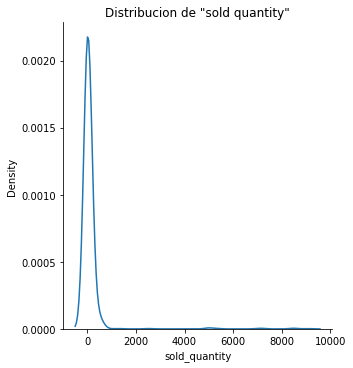

In [402]:
ax = sns.displot(df.sold_quantity, kind='kde')
ax.ax.set_title('Distribucion de "sold quantity"')
plt.show()

De por si vemos que la cantidad de ventas muy grandes corresponde a unos pocas publicaciones.

In [270]:
df.describe(exclude=[np.number])

,site_id,currency_id,buying_mode,listing_type_id,condition,accepts_mercadopago,original_price,seller_seller_reputation_level_id,shipping_free_shipping,address_state_name,BRAND,MODEL
count,994,994,994,994,994,994,85,938,994,994,993,992
unique,1,1,1,2,2,1,49,4,2,13,61,365
top,MLA,ARS,buy_it_now,gold_special,new,True,34999,5_green,True,Capital Federal,Samsung,A31
freq,994,994,994,627,875,994,5,880,892,638,310,22


In [271]:
# Exploramos algunas variables categoricas que desconozco los posibles valores
display(df.seller_seller_reputation_level_id.value_counts(dropna=False))
display(df.condition.value_counts(dropna=False))
df.listing_type_id.value_counts(dropna=False)

5_green          880
NaN               56
3_yellow          46
2_orange           9
4_light_green      3
Name: seller_seller_reputation_level_id, dtype: int64

new     875
used    119
Name: condition, dtype: int64

gold_special    627
gold_pro        367
Name: listing_type_id, dtype: int64

In [272]:
# Chequeamos la proporción de missings
(df.isna().sum() / df.shape[0] * 100).sort_values(ascending=False)

original_price                       91.448692
seller_seller_reputation_level_id     5.633803
MODEL                                 0.201207
BRAND                                 0.100604
condition                             0.000000
price                                 0.000000
currency_id                           0.000000
available_quantity                    0.000000
sold_quantity                         0.000000
buying_mode                           0.000000
listing_type_id                       0.000000
descuento_USD                         0.000000
accepts_mercadopago                   0.000000
descuento_precio                      0.000000
shipping_free_shipping                0.000000
address_state_name                    0.000000
price_USD                             0.000000
discount                              0.000000
site_id                               0.000000
dtype: float64

Dado que hay valores missingpara `seller_reputation`, seguramente porque el usario tenga pocas ventas, voy a asignarle un valor entre el 3  y el 4, porque para mi alguien sin info da mas confianza que alguien en amarillo (esto es subjetivo, lo se, pero vamos a ir con este supuesto).

In [273]:
df.seller_seller_reputation_level_id.fillna('3.5_sin_info', inplace=True)

Como vemos todos los productos estan expresados en pesos (`buying_mode`),  son todos del tel tipo `buy_it_now` y todos aceptan mercado pago. Por ende vamos a quitar estas variables de nuestro dataset. 

Al mismo tiempo vamos a optar por no usar `original_price` dado que solo tenemos valores para menos del 9% de los datos y correlaciona con la variable `discount` la cual es binaria. 

In [274]:
to_remove = ['site_id','currency_id', 'buying_mode', 'accepts_mercadopago', 'MODEL','original_price']
df.drop(columns=to_remove, inplace=True)

Dado que hay demasiados modelos diferentes (365) y abundantes marcas (61) vamos a realizar una transformación en esta última variable.

In [275]:
display(df.BRAND.value_counts(normalize=True)[:10] * 100)
top_5p = df.BRAND.value_counts(normalize=True)[df.BRAND.value_counts(normalize=True) > 0.048].index
print(f'Top 4.8%: {list(top_5p)}')

Samsung     31.218530
Motorola    12.688822
Apple        8.660624
LG           8.157100
Xiaomi       5.941591
Alcatel      4.833837
BLU          4.632427
Nokia        2.920443
Kodak        2.416918
TCL          2.215509
Name: BRAND, dtype: float64

Top 4.8%: ['Samsung', 'Motorola', 'Apple', 'LG', 'Xiaomi', 'Alcatel']


Vamos a crear una nueva variable con los modelos que al menos tienen un 5% de casos. Sino pasarán a la categoría otros

In [276]:
df['brand_top'] = df.BRAND.apply(lambda x: x if x in top_5p else 'Otro')

De la misma manera tenemos 13 states o provincias de las cuales Capital Federal y Buenos Aires condensan el 90 de las ventas.<br>
Vamos a transformar esta variable.

In [277]:
display(df.address_state_name.value_counts(normalize = True) * 100)
df['big_hub'] = df.address_state_name.apply(lambda x: x if x in ['Capital Federal', 'Buenos Aires'] else 'Otro')

Capital Federal        64.185111
Buenos Aires           25.050302
Misiones                3.722334
Santa Fe                3.219316
Córdoba                 1.710262
Tucumán                 0.804829
Entre Ríos              0.503018
Jujuy                   0.201207
La Pampa                0.201207
San Juan                0.100604
Salta                   0.100604
Río Negro               0.100604
Santiago del Estero     0.100604
Name: address_state_name, dtype: float64

Exploramos los outliers de precios bajos(`price`), `available_quantity` y `sold_quantity`

In [278]:
df.describe()

,price,available_quantity,sold_quantity,price_USD,discount,descuento_precio,descuento_USD
count,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000
mean,38162.568873,64.069416,104.230382,422.241990,0.085513,387.161851,4.283674
std,49577.176027,343.188779,664.581558,548.536592,0.279784,1581.842060,17.501970
min,100.000000,1.000000,0.000000,1.106430,0.000000,0.000000,0.000000
25%,14299.000000,1.000000,2.000000,158.208381,0.000000,0.000000,0.000000
50%,22900.000000,1.000000,5.000000,253.372398,0.000000,0.000000,0.000000
75%,39924.000000,1.000000,25.000000,441.730987,0.000000,0.000000,0.000000
max,450000.000000,7553.000000,9075.000000,4978.933579,1.000000,16000.000000,177.028749


In [279]:
# Eliminamos celulares menores a 20 USD
df = df[df.price_USD >= 20]
display(df.shape)
df.describe()

(984, 15)

,price,available_quantity,sold_quantity,price_USD,discount,descuento_precio,descuento_USD
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000
mean,38540.849045,64.609756,105.231707,426.427394,0.086382,391.096423,4.327207
std,49685.596179,344.874858,667.877025,549.736185,0.281070,1589.383188,17.585407
min,2000.000000,1.000000,0.000000,22.128594,0.000000,0.000000,0.000000
25%,14499.000000,1.000000,2.000000,160.421240,0.000000,0.000000,0.000000
50%,22999.000000,1.000000,5.000000,254.467763,0.000000,0.000000,0.000000
75%,39999.000000,1.000000,25.000000,442.560809,0.000000,0.000000,0.000000
max,450000.000000,7553.000000,9075.000000,4978.933579,1.000000,16000.000000,177.028749


Removiendo los outliers bajos, removimos solo 10 casos. Podemor tolerar esto (casi el 1% de nuestros datos originales).<br>
Para el caso de  `available_quantity` y `sold_quantity` tenemos una std muy amplio, pero si bien los valos son altos no parecen ser son anomalos. Proseguiremos sin hacer ningún cambio en este caso.


Vamos a eliminar la variable `price_USD` dado que no hay ningún valor expresado en dolares. Y vamos a eliminar las variables a las cuales les aplicamos alguna transformación.

In [280]:
df = df.drop(columns=['address_state_name', 'BRAND', 'price_USD'])

## Visualizando de relaciones entre variables

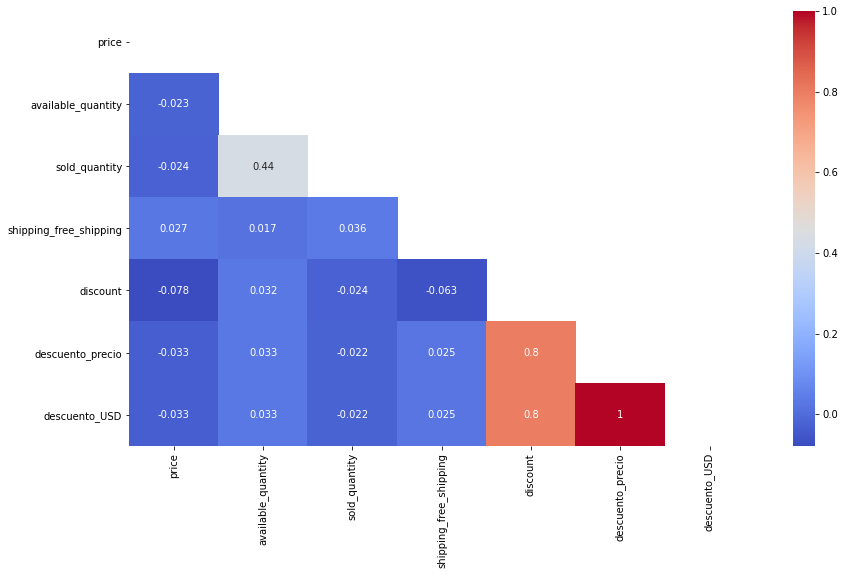

In [281]:
# Correlaciones
corr = df.corr()
mask=np.triu(np.ones(corr.shape)).astype(np.bool)
plt.figure(figsize = (14,8))
ax = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap='coolwarm',
            annot = True,
            mask = mask
           )


In [283]:
# Vamos a evaluar utilizando el predictive power score
ppscore.predictors(df, "sold_quantity").sort_values('model_score')

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
1,available_quantity,sold_quantity,0,regression,True,mean absolute error,102.912602,145.768508,DecisionTreeRegressor()
9,brand_top,sold_quantity,0,regression,True,mean absolute error,102.912602,161.776857,DecisionTreeRegressor()
3,condition,sold_quantity,0,regression,True,mean absolute error,102.912602,162.085392,DecisionTreeRegressor()
2,listing_type_id,sold_quantity,0,regression,True,mean absolute error,102.912602,162.672082,DecisionTreeRegressor()
10,big_hub,sold_quantity,0,regression,True,mean absolute error,102.912602,163.619381,DecisionTreeRegressor()
4,seller_seller_reputation_level_id,sold_quantity,0,regression,True,mean absolute error,102.912602,164.467320,DecisionTreeRegressor()
5,shipping_free_shipping,sold_quantity,0,regression,True,mean absolute error,102.912602,165.055483,DecisionTreeRegressor()
6,discount,sold_quantity,0,regression,True,mean absolute error,102.912602,165.720772,DecisionTreeRegressor()
8,descuento_USD,sold_quantity,0,regression,True,mean absolute error,102.912602,165.723385,DecisionTreeRegressor()
7,descuento_precio,sold_quantity,0,regression,True,mean absolute error,102.912602,166.042152,DecisionTreeRegressor()


No parece ser que las variables seleccionadas nos sean de mucha utilidad. La correlacion es muy baja entre las varaibles y el target. Asimismo el predictive power score es muy bajo. Sin embargo no podemos descartar que haya interacciones no lineales entre las variables. 

Vamos a continuar.

## Preprocesamiento

In [378]:
# Vamos a transformar a nuestras variables categoricas.
column_trans = make_column_transformer(
    (OneHotEncoder(),
     ['big_hub','brand_top','listing_type_id']),
    (OrdinalEncoder(
        categories=[['gold_pro','gold_special'],
                    ['used','new'],
                    ['2_orange','3_yellow','3.5_sin_info','4_light_green','5_green']
                   ]),
     ['listing_type_id','condition','seller_seller_reputation_level_id']),
    


    # Asumo que new y used son los unicos estados, por ende binario y ordinal. Idem con listing_type
    # Se que en producción y podría tener otros listing (creo). Pero vamos a proceder asi para este challenge
    remainder='passthrough'
)
y = df.sold_quantity
X = df.drop(columns = 'sold_quantity')
column_trans.fit(X)
x_train, x_test, y_train, y_test = train_test_split(X,y,random_state = 10)  #  Divido en train test, pero bien 
# podría usar un CV con todo el dataset y sugerir ese modelo para el futuro.

## Entrnamiento y Evaluación de resultados

### Baseline

In [356]:
print(f'Si no tuviera mas datos que valores anteriores para hacer una estimación yo '\
      f'diria que todo celular publicado tendrá un sold_quantity de: {y_train.median()}')

Si no tuviera mas datos que valores anteriores para hacer una estimación yo diria que todo celular publicado tendrá un sold_quantity de: 5.0


In [357]:
mse = mean_squared_error(y_test,
                         np.full(
                             y_test.shape[0],
                             y_train.median()
                         )
                        )
rmse = np.sqrt(mean_squared_error(y_test, np.full(y_test.shape[0],y_train.median())))
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Squared Error: 309605.53
Root Mean Squared Error: 556.42


### Linear Regression

In [411]:
lr = LinearRegression()
pipe_lr = make_pipeline(column_trans, StandardScaler(), lr)
pipe_lr.fit(x_train,y_train)
mse = mean_squared_error(pipe_lr.predict(x_test), y_test)
rmse = np.sqrt(mean_squared_error(pipe_lr.predict(x_test), y_test))
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Squared Error: 484701.26
Root Mean Squared Error: 696.20


A primera vista parece que el modelo performa incluso peor que la Baseline. Prosigamos con un modelo más robusto.

### Random Forest 

Random Forest deberia ser una opción más robusta para la predicción. No es sensible a la colinearidad y no requiere la normalización de las features.

In [412]:
#Modelo
rf_reg = RandomForestRegressor()
#Pipeline
pipe_rf = make_pipeline(column_trans, rf_reg)
# CV para ver que tal performarían
rmse_cv = abs(cross_val_score(pipe_rf, x_train, y_train, cv=20, scoring='neg_root_mean_squared_error'))
print(f'Root Mean Squared Error: {rmse_cv.mean():.2f}(SD={rmse_cv.std():.2f})')

Root Mean Squared Error: 442.02(SD=420.84)


Si bien el CV nos dice que el RMSE es menor al BaseLine y a la Regresión Lineal, podemos ver un gran SD. Esto es indicador de
que nuestro modelo tiene demasiada variabilidad y la metrica observada no puede ser garantizada en producción. Veamos con el test set. 

In [413]:
# Asumimos que entrenamos con todos nuestros datos. Y estamos listos para producción.
pipe_rf.fit(x_train,y_train)
# Metricas - Performance estimada frente a 'nuevos' casos.
mse = mean_squared_error(y_test,pipe_rf.predict(x_test))
rmse = np.sqrt(mean_squared_error(y_test,pipe_rf.predict(x_test)))
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Squared Error: 378195.78
Root Mean Squared Error: 614.98


Observamos nuevamente que el modelo al simular su puesta en producción no logra superar a nuestra Baseline. Evidentemente y como observamos más arriba, las variables que componen al modelo no son informativas, o al menos no suficientemente.

Un problema puede ser que los modelos usados no logran encontrar una relación entre las multiples variables. Vamos a reducir nuestro numero de variable para ver si podemos mejorar nuestras predicciones.

In [443]:
# Preparando la data
#Vamos a usar menos variables
column_trans = make_column_transformer(
    (OneHotEncoder(),
     ['big_hub']),
    (OrdinalEncoder(
        categories=[
                    ['used','new'],
                    ['2_orange','3_yellow','3.5_sin_info','4_light_green','5_green']
                   ]),
     ['condition','seller_seller_reputation_level_id']),
    remainder='passthrough'
)
y = df.sold_quantity
X = df[['big_hub','condition','seller_seller_reputation_level_id']]
column_trans.fit(X)
x_train, x_test, y_train, y_test = train_test_split(X,y,random_state = 10)

#Modelo
rf_reg = RandomForestRegressor()
#Pipeline
pipe_rf = make_pipeline(column_trans, rf_reg)
# CV para ver que tal performarían
rmse_cv = abs(cross_val_score(pipe_rf, x_train, y_train, cv=20, scoring='neg_root_mean_squared_error'))
print(f'Root Mean Squared Error: {rmse_cv.mean():.2f}(SD={rmse_cv.std():.2f})')

Root Mean Squared Error: 516.20(SD=466.75)


Vemos que la disminución de variables no mejoro el poder predictivo en comparación con el modeo de RF inicial. Es màs lo redujo e incremento su SD.

## Limitaciones

No se pudo realizar un modelo que sea substancialmente mejor que la línea de base.

Se podría realizar más pruebas como:
- Tuneo de hiper parámetros
- Selección de mas variables y aplicar algun feature selection method como SelectKBest
- Probar otros modelos
- Crear nuevas features con la información actual
- Incrementas los datos